In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline

I will define a function here for future usage during the plotting stage.

In [60]:
# Used to make plot details more clear and readable
def num_format(x, pos):
    return '{}'.format(x / 1000000.0)

x_format = tkr.FuncFormatter(num_format)
y_format = tkr.FuncFormatter(num_format)

In [34]:
chart_df = pd.read_csv('./data/chart_data.csv', index_col=0)

chart_df['Token'] = [chart_df['Song Links'][item].split('/')[-1] for item in range(0, len(chart_df['Song Links']))]

chart_df.dropna(axis=0, how='any', subset=['Artist'], inplace=True)

chart_df.drop(labels=['Song Links'], axis=1, inplace=True)

chart_df2 = chart_df.groupby(['Token']).agg({'Streams' : sum})

chart_df2.head()

,Streams
Token,
00EPIEnX1JFjff8sC6bccd,29236210
00ko9WaS4jOX1kEk3gvHjf,13404569
00mrTzjxIRuWJY01sRBJmO,877954
00v5O7qsglyTtp2q1M9DZr,1155602
01DOm09B2AbiTARAbXVI6g,10407677


In [41]:
chart_df = chart_df2.merge(chart_df, how='left', left_on='Token', right_on='Token')

chart_df.drop(labels=['Streams_y'], axis=1, inplace=True)

chart_df.drop_duplicates(subset=['Token'], keep='last', inplace=True)

chart_df.rename(columns={'Streams_x': 'Streams'}, inplace=True)

chart_df.head()

,Token,Streams,Title,Artist,Date
36,00EPIEnX1JFjff8sC6bccd,29236210,No Me Acuerdo,Thalía,2018-11-08
51,00ko9WaS4jOX1kEk3gvHjf,13404569,Hot Shower,Chance the Rapper,2019-08-13
52,00mrTzjxIRuWJY01sRBJmO,877954,Dark Side Of The Moon (feat. Nicki Minaj),Lil Wayne,2018-10-03
53,00v5O7qsglyTtp2q1M9DZr,1155602,Pray You Catch Me,Beyoncé,2019-04-23
65,01DOm09B2AbiTARAbXVI6g,10407677,CHopstix (with Travis Scott),ScHoolboy Q,2019-04-20


In [42]:
song_df = pd.read_csv('./data/song_data.csv', index_col=0)

song_df.drop(labels=['Title', 'Artist', 'Streams', 'Date'], axis=1, inplace=True)

song_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 9 columns):
Token               1886 non-null object
Duration            1886 non-null int64
Loudness            1886 non-null float64
Speechiness         1886 non-null float64
Energy              1886 non-null float64
Tempo               1886 non-null float64
Valence             1886 non-null float64
Instrumentalness    1886 non-null float64
Modality            1886 non-null int64
dtypes: float64(6), int64(2), object(1)
memory usage: 147.3+ KB


In [43]:
artist_df = pd.read_csv('./data/artist_data.csv', index_col=0)

artist_df.drop(labels=['Title', 'Streams', 'Date'], axis=1, inplace=True)

artist_df.sample(10)

,Artist,Followers
195,Summer Walker,534292
142,The Weeknd,17289675
130,a-ha,955347
380,R3HAB,1819163
224,Tropkillaz,165670
18,KitschKrieg,63128
172,Felipe Araújo,2392958
483,es,2101
475,Lil Tecca,810440
231,James Bay,2514052


In [44]:
data_df_temp = chart_df.merge(song_df, how='left', left_on='Token', right_on='Token')

data_df = data_df_temp.merge(artist_df, how='left', left_on='Artist', right_on='Artist')

In [45]:
data_df.head()

,Token,Streams,Title,Artist,Date,Duration,Loudness,Speechiness,Energy,Tempo,Valence,Instrumentalness,Modality,Followers
0,00EPIEnX1JFjff8sC6bccd,29236210,No Me Acuerdo,Thalía,2018-11-08,217653,-4.247,0.0873,0.799,94.033,0.7720,0.0000,0,2203867
1,00ko9WaS4jOX1kEk3gvHjf,13404569,Hot Shower,Chance the Rapper,2019-08-13,225924,-7.578,0.3740,0.522,149.986,0.6230,0.0000,1,4379848
2,00mrTzjxIRuWJY01sRBJmO,877954,Dark Side Of The Moon (feat. Nicki Minaj),Lil Wayne,2018-10-03,242972,-5.384,0.2970,0.457,73.724,0.4580,0.0000,1,8328932
3,00v5O7qsglyTtp2q1M9DZr,1155602,Pray You Catch Me,Beyoncé,2019-04-23,196000,-13.676,0.0380,0.218,175.844,0.0786,0.0668,0,20350283
4,01DOm09B2AbiTARAbXVI6g,10407677,CHopstix (with Travis Scott),ScHoolboy Q,2019-04-20,181153,-6.996,0.1180,0.600,127.933,0.6070,0.0000,0,2756517


In [47]:
lr = LinearRegression()

X = data_df.iloc[:, 5:]

y = data_df.iloc[:, 1]


lr.fit(X, y)

lr.score(X,y)

0.04748575686275436

In [48]:
X, y = data_df.iloc[:, 5:], data_df['Streams']

#20% gets withheld for testing purposes
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

#Another 20% is withheld for validation, leaving 60% for training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [49]:
lm = LinearRegression()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [50]:
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.052
Ridge Regression val R^2: 0.052
Degree 2 polynomial regression val R^2: 0.009


In [51]:
lm_poly.fit(X,y)
print(f'Linear Regression val R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression val R^2: 0.024


In [52]:
from sklearn.model_selection import KFold

X, y = data_df.iloc[:,5:], data_df['Streams']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [53]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.005796638552944766, 0.057906531870359546, 0.017216767428353763, 0.047703155489297044, 0.03374790939772132]
Ridge scores:  [0.005848685940944454, 0.05785526104874383, 0.01725442087246265, 0.04775346411143755, 0.03376123525519237] 

Simple mean cv r^2: 0.032 +- 0.019
Ridge mean cv r^2: 0.032 +- 0.019


In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.026


In [57]:
lasso_model = Lasso(alpha = 100000) 
lasso_model.fit(X_train, y_train)

Lasso(alpha=100000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
columns = ['Duration', 'Loudness', 'Speechiness', 'Energy', 'Tempo', 'Valence', 'Instrumentalness', 'Modality', 'Followers']
list(zip(columns, lasso_model.coef_))

[('Duration', 5.470435175168934),
 ('Loudness', 5879472.507806241),
 ('Speechiness', -33745300.412992045),
 ('Energy', -73131438.85233325),
 ('Tempo', -49527.34198550128),
 ('Valence', 37897622.12123547),
 ('Instrumentalness', -0.0),
 ('Modality', -8426960.323174482),
 ('Followers', 1.571303504100804)]

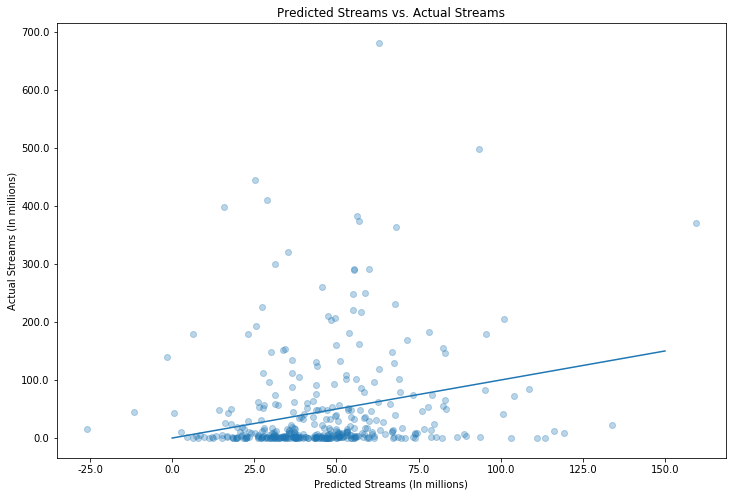

In [65]:
test_set_pred = lasso_model.predict(X_test)
plt.figure(figsize=(12,8))
plt.scatter(test_set_pred, y_test, alpha=.3)
plt.plot(np.linspace(0,150000000,10000), np.linspace(0,150000000,10000));
plt.title('Predicted Streams vs. Actual Streams')
plt.xlabel('Predicted Streams (In millions)')
plt.ylabel('Actual Streams (In millions)')
plt.gca().xaxis.set_major_formatter(x_format)
plt.gca().yaxis.set_major_formatter(y_format)
plt.savefig('comparison.png', format='png')

In [63]:
r2_score(y_test, test_set_pred)

0.023942132312039566

In [66]:
# data_df.head()

,Token,Streams,Title,Artist,Date,Duration,Loudness,Speechiness,Energy,Tempo,Valence,Instrumentalness,Modality,Followers
0,00EPIEnX1JFjff8sC6bccd,29236210,No Me Acuerdo,Thalía,2018-11-08,217653,-4.247,0.0873,0.799,94.033,0.7720,0.0000,0,2203867
1,00ko9WaS4jOX1kEk3gvHjf,13404569,Hot Shower,Chance the Rapper,2019-08-13,225924,-7.578,0.3740,0.522,149.986,0.6230,0.0000,1,4379848
2,00mrTzjxIRuWJY01sRBJmO,877954,Dark Side Of The Moon (feat. Nicki Minaj),Lil Wayne,2018-10-03,242972,-5.384,0.2970,0.457,73.724,0.4580,0.0000,1,8328932
3,00v5O7qsglyTtp2q1M9DZr,1155602,Pray You Catch Me,Beyoncé,2019-04-23,196000,-13.676,0.0380,0.218,175.844,0.0786,0.0668,0,20350283
4,01DOm09B2AbiTARAbXVI6g,10407677,CHopstix (with Travis Scott),ScHoolboy Q,2019-04-20,181153,-6.996,0.1180,0.600,127.933,0.6070,0.0000,0,2756517


In [67]:
# stream_model = smf.ols('Streams ~ Duration + Loudness + Speechiness + Energy + Tempo + Valence + Instrumentalness + Modality + Followers', data=data_df).fit()

In [68]:
# print(stream_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Streams   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     10.39
Date:                Fri, 11 Oct 2019   Prob (F-statistic):           8.38e-16
Time:                        09:58:08   Log-Likelihood:                -37342.
No. Observations:                1886   AIC:                         7.470e+04
Df Residuals:                    1876   BIC:                         7.476e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.204e+08   2.32e+07  

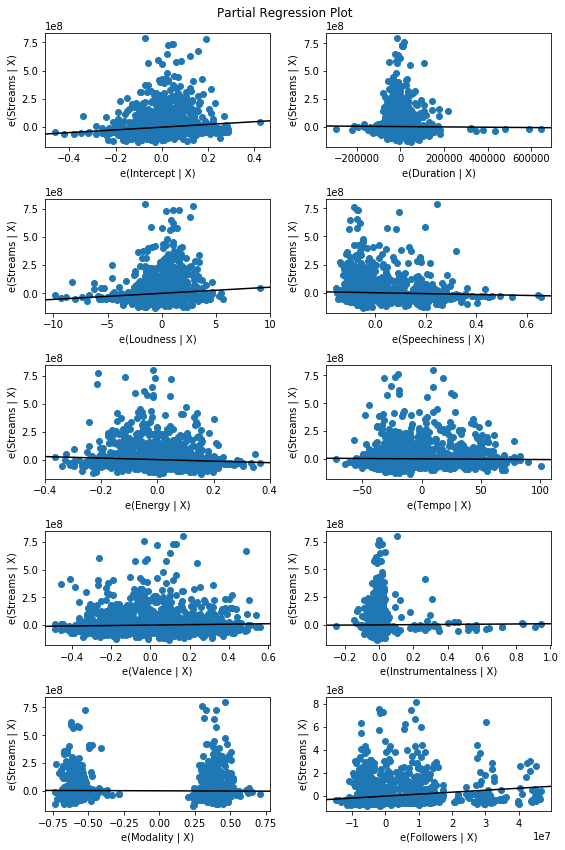

In [70]:
# fig = plt.figure(figsize=(8,12))
# fig = sm.graphics.plot_partregress_grid(stream_model, fig=fig)
# plt.savefig('partials.png', format='png')